In [1]:
import numpy as np
import scipy.linalg as scl
import matplotlib.pyplot as plt

# Sparse Fourier approximation

### Discrete Fourier transform as a linear operator
Let's now consider two discretized signals $x_1, x_2$ that are periodic of period of period N: $x_i[n+N]=x_i[n]$.

The discrete fourier transform reads:
\begin{align*}
  X[k]= \sum_{n=0}^{N-1} x[n]e^{-2 \pi j \frac{kn}{N}}
\end{align*}
And the inverse discrete fourier transform reads:
\begin{align*}
  x[n]= \frac{1}{N} \sum_{k=0}^{N-1} X[k]e^{2 \pi j \frac{kn}{N}}
\end{align*}

it is very interesting to see that each element of the direct space is the result of a dot product with Fourier space basis, and conversely, each element of the Fourier space is also the result of a dot product with a vector of the analysis Fourier basis.
This is much more clear if we write the discrete Fourier transform as a matrix F:
$X = F^{-1} x$ and $x = F X$ where we have:

\begin{align}
    F = \frac{1}{N} \begin{pmatrix}
    1 & 1 & \cdots & 1\\
    1 & e^{2\pi j\frac{1}{N}} & \cdots & e^{2\pi j\frac{N-1}{N}}\\
    \vdots & \vdots & \vdots & \vdots \\
    1 & e^{2\pi j\frac{N-1}{N}} & \cdots & e^{2\pi j\frac{(N-1)(N-1)}{N}}\\
    \end{pmatrix}
\end{align}
where k indices are constant across a row, but are different along a column
and
 
\begin{align}
    F^{-1} = \begin{pmatrix}
    1 & 1 & \cdots & 1\\
    1 & e^{-2\pi j\frac{1}{N}} & \cdots & e^{-2\pi j\frac{N-1}{N}}\\
    \vdots & \vdots & \vdots & \vdots \\
    1 & e^{-2\pi j\frac{N-1}{N}} & \cdots & e^{-2\pi j\frac{(N-1)(N-1)}{N}}\\
    \end{pmatrix}
\end{align}
where n indices are constant across row, but are different along a column



In [2]:
# Simple numerical check of the definitions above
N = 4
F = np.zeros((N,N), dtype=np.complex64)
Fm = np.zeros_like(F)
ks = np.arange(N)
ns = np.arange(N)

# definition of F
for n in ns:
    F[n,:] = np.exp(2*np.pi*1j*ks*n/N)
F = F/N

# definition of F^(-1)
for k in ks:
    Fm[k,:] = np.exp(-2*np.pi*1j*k*ns/N)

# Small random test with vector, notice there is no FFTSHIFT here !
x=np.random.rand(N)+1j*np.random.rand(N)
r=np.dot(F,x)
assert np.allclose(r,np.fft.ifft(x)), 'F is not numerically close to ifft'
r=np.dot(Fm,x)
assert np.allclose(r,np.fft.fft(x)), 'Fm is not numerically close to fft'
# Check if they are inverse of each other
assert np.allclose(np.dot(F,Fm), np.identity(N, dtype=np.complex64), atol=1e-5), 'F and Fm are not numerically each other inv'
assert np.allclose(np.dot(Fm,F), np.identity(N, dtype=np.complex64), atol=1e-5), 'Fm and F are not numerically each other inv'

## Alternative definition of Fourier transform as a unitary matrix, and its property

### Definition of $G$
It is interesting to notice that, depending on a scaling factor used for our definition, we can write that $G = \frac{1}{\sqrt{N}} F$ is a unitary matrix.
Ie the following equalities holds:
* $G.G^{\star} = Id(N)$
* $G^{\star}.G = Id(N)$

We recall that $G^{\star}$ is called the adjoint matrix of $G$, it is the transpose of G where each coefficient has been conjugated.
This construction is also sometimes called the Hermitian conjugate.
Showing that $\frac{1}{\sqrt{N}} F$ is the actual adjoint of $\sqrt{N} F^{-1}$ is rather easy if you notice that those matrices are both symmetric, and that $\overline{e^{\alpha j}} = e^{-\alpha j}$

The fact that the product makes them unitary is also pretty easy when dividing the output in two case:
* on diagonal: each term in the sum has the form $e^{\alpha j} \times e^{-\alpha j} = 1$ and the $\frac{1}{\sqrt{N}$ makes the overall norm to be 1
* off diagonal: We can reorder all the terms to exhibit 1 on one side minus the formula for partition of unity on the other side which amounts to zero.

### Orthonogonality for complex valued vectors
The very nice property that arise when one matrix verify the unitary property is the orthogonality of its column vector. When working on the field of real numbers, unitary matrices and orthonormal matrices have the same definition because transpose (orthonormal) is the same as hermitian transpose (unitary).

On the field of complex number, we talk about unitary matrices, but the semantic behind is close: you can see directly from $G.G^{\star} = Id(N)$ that each column vector of $G$ is either orthogonal with the other, or colinear with itself, and has norm 1.

Working on a field equipped with an hermitian product helps define useful algebraic structure like Hilbert spaces.

### Unitary matrices are stable
The product of two unitary matrices is another unitary matrix. The inverse of a unitary matrix is another unitary matrix, and identity matrices are unitary. Hence the set of unitary matrices form a group, called the unitary group.

This property is especially usefull when composing transformations.

### Unitary does not mean hermitian
Hermitian symmetry extends some of the properties of symmetric matrices to the complex field, like positive semi-definiteness:  $<z, Mz> = z^{\star} M z \geq 0 \forall z$.

In the case of complex number, hermitian matrices are defined as: $A \; \text{s.t} \; a_{ij} = \overline{a_{ij}}$

All hermitian matrices are positive semi definite. But there is no reason for our Fourier matrix $G$ to be hermitian


### Spectral theorem for normal matrices
We also recall that unitary matrices are also commuting matrices by construction: $AB = BA$ when one matrix commutes with its adjoint we also say that this matrix is normal.

One can show that A is normal if and only if it is unitarily diagonalizable:
\begin{align}
    &G = V D V^{\star}
\end{align}
Where $V$ is also a unitary matrix. The proof uses Schurr decomposition.

Interestingly, given the unitary property in addition, both $G^{\star}$ and $G$  have all their eigenvalues lying on the unit circle. This can be shown using the fact that unitary matrices preserve the Hermitian inner product:

\begin{align}
    &<\vec{v},\vec{w}>=\overline{<\vec{w},\vec{v}>} \; \text{and we have} \\
    &<\vec{v},\vec{w}>=<G\vec{v},G\vec{w}>
\end{align}

In [3]:
# Lets define G and numerically check previous properties
F = np.zeros((N,N), dtype=np.complex64)
for n in ns:
    F[n,:] = np.exp(2*np.pi*1j*ks*n/N)
G = F/np.sqrt(N)

# definition of G^(-1)
Fm = np.zeros_like(F)
for k in ks:
    Fm[k,:] = np.exp(-2*np.pi*1j*k*ns/N)
Gm = Fm/np.sqrt(N)

def check_unitary_matrices(A, B, atol=1e-5):
    # Check if they are adjoint of each other.
    assert np.allclose(A.T.conj(), B, atol=atol), 'A adjoint is not numerically close to B'
    assert np.allclose(B.T.conj(), A, atol=atol), 'B adjoint is not numerically close to A'

    # Now check invert
    assert np.allclose(np.dot(A.T.conj(), A), np.identity(N, dtype=np.complex64), atol=atol), 'A adjoint is not numerically close to A inverse'
    assert np.allclose(np.dot(A, A.T.conj()), np.identity(N, dtype=np.complex64), atol=atol), 'A adjoint is not numerically close to A inverse'
    
check_unitary_matrices(G, Gm)

# This was not working IN GENERAL with original definition of F and Fm
assert not np.allclose(np.dot(F.T.conj(), F), np.identity(N, dtype=np.complex64), atol=1e-5), 'F adjoint is numerically close to Gm inverse in general !'
assert not np.allclose(np.dot(Fm.T.conj(), Fm), np.identity(N, dtype=np.complex64), atol=1e-5), 'Fm adjoint is not numerically close to F inverse in general !'

# Check for diagonalization with unitary matrices with SVD
u,s,vh = np.linalg.svd(G, full_matrices=False)
Ddiag = np.diag(s)
assert np.allclose(np.abs(Ddiag), np.identity(N, dtype=np.complex64), atol=1e-5), 'Ddiag has not all unit singular values'
assert np.allclose(np.dot(u, np.dot(Ddiag, vh)), G, atol=1e-5), 'SVD reconstruction is not ok'
check_unitary_matrices(u, u.T.conj())
check_unitary_matrices(vh.T.conj(), vh)
# Surprisingly here, SVD does not give a numerically accurate estimate: u and vh are not adjoint of each other
assert not np.allclose(u.T.conj(), vh, atol=1e-5), 'SVD does not provide numerically close result'

# Check for diagonalization with unitary matrices with ED
w,v = np.linalg.eig(G)
Ddiag = np.diag(w)
#print(np.dot(v, v.T.conj()))
assert np.allclose(np.abs(Ddiag), np.identity(N, dtype=np.complex64), atol=1e-5), 'Ddiag has not all unit singular values'
# This is the expected reconstruction formula for eigen decomposition
assert np.allclose(np.dot(v, np.dot(Ddiag, np.linalg.inv(v))), G, atol=1e-5), 'QDQ-1 reconstruction is not ok'

#It is not clear why those two properties related to unitary diagonalization do not hold up to a good precision ?
check_unitary_matrices(v, v.T.conj(), atol=1e-1)
assert np.allclose(np.dot(v, np.dot(Ddiag, v.T.conj())), G, atol=1e-1), 'DQt reconstruction is not ok'

## Fourier matrices diagonalizes circulant matrices

Although this is not relevant to our current problem, we would like to recall this important property of the discrete Fourier transform, especially for "numerical" people use this powerful tool.

### Circular convolution as a linear operator
We also recall that discrete circular convolution reads:
\begin{align*}
  (s_1 \star s_2)[n] = \sum_{k=0}^{N-1} s_1[k] s_2[(n-k)\%N]
\end{align*}

It is interesting to notice that this convolution operator can be expressed as a linear operation, $(s_1 \star s_2) = S_2 s_1$ where we have:
\begin{align}
    S_2 = \begin{pmatrix}
    s_2[0] & s_2[N-1] & \cdots & s_2[1] \\
    s_2[1] & s_2[0] & \cdots & s_2[2] \\
    \vdots & \vdots & \vdots & \vdots \\
    s_2[N-1] & s_2[N-2] & \cdots & s_2[0] \\
    \end{pmatrix}
\end{align}
And one can easily see that this matrix is a circulant matrix

### Diagonalization of circulant matrices
From there, one can show that the $F, F^{-1}$ pair of matrices can be used to diagonalize any circulant matrices $C$. such that we can write $C = F D F^{-1}$ or, alternatively $D = F^{-1} C F$

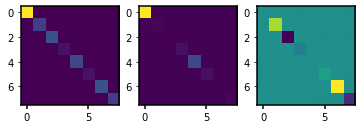

In [4]:
"""
  Check if fourier transform allows to diagonalize a circulant matrix
"""
N=8

#now generate the Fourier matrix
x = np.linspace(0, N-1, N) 
y = np.linspace(0, N-1, N)
xg, yg = np.meshgrid(x, y)
F=(1/N)*np.exp(2*np.pi*1j*xg*yg/N)
Fm=np.exp(-2*np.pi*1j*xg*yg/N)

#check that F and F_1 are inverse of each other
assert np.allclose(np.dot(F,Fm), np.identity(N)), 'Fm is not an inverse of F'

#Lets check in practice that Fourier matrix can be used to diagonalize circulant matrices
circulant=scl.circulant(np.random.randint(0,100,N))

#Now show the diagonalized version of the circulant matrix:
diag = np.dot(Fm,np.dot(circulant,F))

# Check reconstruction
assert np.allclose(circulant, np.dot(F, np.dot(diag,Fm))), 'Cannot reconstruct '
diag = np.dot(Fm,np.dot(circulant,F))

fig,ax = plt.subplots(1,3)
ax[0].imshow(np.absolute(diag))
ax[1].imshow(np.real(diag))
ax[2].imshow(np.imag(diag))

## Sparse approximation in Fourier domain

### Introduction:

In a quite famous paper, Bruckstein, Donoho and Elad have explored the link between the fundamental uncertainty principle (see our notebook on the Heisenberg–Pauli–Weyl inequality) and the resolution of systems of linear equations, the name of the paper was: From sparse solutions of systems of equations to sparse modeling of signals and images.

### Original problem

A natural way to formalize the sparsity problem in Fourier domain, given a linear operator $M$ in the context of inverse problem, is to use a $L_0$ norm penalty on the Fourier coefficient.
It is interesting to notice that the problem can either be casted as an "Analysis" problem:

\begin{align}
 \underset{x\in \mathbb{R}^N}{\text{argmin}} \qquad \| Mx - y \|_2^2 + \lambda \|G^{-1}x\|_0
\end{align}

or a "Synthesis" problem:
\begin{align*}
 \underset{x\in \mathbb{C}^N \; s.t \; Gx \in \mathbb{R}^N}{\text{argmin}} \qquad & \| MGx - y \|_2^2 + \lambda \|x\|_0 \\
 \underset{x\in \mathbb{C}^N}{\text{argmin}} \qquad & \| MGx - y \|_2^2  + \lambda \|x\|_0 + \chi_{\mathbb{R}^N}(Gx)
\end{align*}

With $\chi_{\mathbb{R}^N}(x)$ the convex indicator function of the set $\mathbb{R}^N$, ie:

\begin{align*}
  \chi_{\mathbb{R}^{N}}(x) &= 
    \begin{cases}0 \qquad &\text{if } x \in \mathbb{R}^{N} \\
    +\infty & \text{otherwise} \end{cases}
\end{align*}

It is not even easy to see here if the analysis problem make sense. At first sight, it seems more simple as it allows to restricts the search space to $\mathbb{R}^N$ instead of $\mathbb{C}^N$ and has less constraint.

On the other side, it is not sure that this formulation will still make sens when we will try to solve the problem: we may have to search inside $\mathbb{C}^N$ and eventually we also might need to use the real signal set indicator: $\chi_{\mathbb{R}^N}(Gx)$.

For people familiar to signal processing, it is well know that real signal have a specific property in Fourier domain:
* Real part of Fourier transform is even
* Imaginary part of Fourier transform is odd

In practice, one can see that the underlying dimension of the problem given the realness of the function in direct domain is the same wether we are trying to solve it in the direct domain or in the Fourier domain.

## $L_1$ relaxation

### Introduction
We won't recall the whole history of sparsity inducing norms, that dates back to the study of variable selection by Robert Tibshirani & Al with the Lasso and elastic net algorithms. Later on, Emmanuel Candes, Donoho, Elad, Terry Tao provided more in depth understanding on the role of sparsity inducing norms, and how they are linked to linear sampling matrices.

Let's just assume here that $\|L_0\|$ norm based functional are generally non convex, and thus cannot be optimized easily. Instead, we will replace $\|L_0\|$ norm by $\|L_1\|$ norm on the vectors coefficient, that favors sparse solutions for the whole system.

The two functionals now reads:

For the analysis problem:
\begin{align}
 \underset{x\in \mathbb{R}^N}{\text{argmin}} \qquad \| Mx - y \|_2^2 + \lambda \|G^{-1}x\|_1
\end{align}

and for the synthesis problem:
\begin{align*}
 \underset{x\in \mathbb{C}^N}{\text{argmin}} \qquad & \| MGx - y \|_2^2  + \lambda \|x\|_0 + \chi_{\mathbb{R}^N}(Gx)
\end{align*}

### Convexity and differentiability, when the complex plane hits you hard.

$L_1$ norm is usually always associated with real coefficients,

We recall the definition of the $L_1$ norm:
\begin{align*}
 \|x\|_1 = \sum_{k=0}^{N-1} x_k
\end{align*}
It simply means the norm of the absolute values, and is valid for both real and complex valued vector as long as you use the proper inner product definition, which is, for the complex case:
\begin{align*}
 |x| &= \left( <x,x> \right)^{\frac{1}{2}} \\
 &= \left( x^{\star}x \right)^{\frac{1}{2}} \\
 &= \left( \overline{x^T}x \right)^{\frac{1}{2}}
\end{align*}

## $L_1$ norm for complex valued vectors and differentiability

Unfortunately, the one norm of a complex vector (the sum of the absolute values of the entries of the vector) is not a differentiable function. In fact, the absolute value of a scalar complex number z=x+i*y is not a differentiable function.

To see this, use the Cauchy-Riemann conditions. Write the absolute value as

abs(z)=abs(x+i*y)=sqrt(x^2+y^2)+i*0

let u(x,y)=sqrt(x^2+y^2) (the real part) and v(x,y)=0 (the imaginary part.)

If the absolute value was differentiable then it would satisfy the Cauchy-Riemann conditions. In particular, the partial derivative of u with respect to x would have to equal the partial derivative of v with respect to y. Since this clearly doesn't hold, there's no need to check the other half of the CR conditions,